# Capstone: SG Food Recommender
Author: Choo Wende

---

<details> 
1. https://towardsdatascience.com/yelp-restaurant-recommendation-system-capstone-project-264fe7a7dea1
2. https://github.com/dominiczrong/yelp-restaurant-recommendation-system
3. https://github.com/jcy10/DSI-Capstone-Project4. https://github.com/nikasso/movie2vec
5. https://github.com/dnaylah/movie-recommender
6. https://towardsdatascience.com/foodiebuddie-how-we-built-singapores-first-food-recommender-b7f3eed0ac77
7. https://github.com/terenceneo/Social-Analytics 
</details>

## Background

## Problem Statement

## Executive Summary

## Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import requests
import re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from datetime import datetime
from nltk.corpus import stopwords

import time
import random

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## Part 1: Webscrapping and Data Cleaning

## 1. WebScrapping Yelp

### Restaurant Info

In [2]:
# Web page used is from yelp.com that is filtered by 99 neighbourhoods.
# Target web page:
url='https://www.yelp.com/search?find_desc=Restaurants&find_loc=Singapore&l=p%3ASG-SG%3ASingapore%3A%3A%5BAlexandra%2CAng_Mo_Kio%2CAnn_Siang_Hill%2CArab_Street%2CBayfront%2CBedok_North%2CBedok_Reservoir%2CBedok_South%2CBencoolen%2CBishan%2CBoat_Quay%2CBoon_Keng%2CBoon_Lay%2CBras_Brasah%2CBuangkok%2CBugis%2CBukit_Batok%2CBukit_Panjang%2CBukit_Timah%2CChangi%2CChinatown%2CChoa_Chu_Kang%2CCity_Hall%2CClarke_Quay%2CClementi%2CDempsey_Hill%2CDhoby_Ghaut%2CDover%2CDuxton_Hill%2CEunos%2CFarrer_Park%2CGeylang%2CGhim_Moh%2CHarbourfront%2CHolland_Hill%2CHolland_Village%2CHougang%2CJoo_Chiat%2CJurong%2CJurong_Island%2CKallang%2CKatong%2CKembangan%2CKent_Ridge%2CKeppel%2CLabrador_Park%2CLavender%2CLim_Chu_Kang%2CLittle_India%2CMacpherson%2CMandai%2CMarine_Parade%2CMount_Sophia%2CMountbatten%2CNewton%2CNovena%2COrchard%2COutram%2CPasir_Panjang%2CPasir_Ris%2CPaya_Lebar%2CPotong_Pasir%2CPulau_Ubin%2CPunggol%2CQueenstown%2CRaffles_Place%2CRedhill%2CRiver_Valley%2CRobertson_Quay%2CSeletar%2CSembawang%2CSengkang%2CSentosa%2CSerangoon%2CSerangoon_Gardens%2CSiglap%2CSimei%2CSixth_Avenue%2CSomerset%2CTampines%2CTanglin%2CTanglin_Halt%2CTanjong_Pagar%2CTanjong_Rhu%2CTelok_Blangah%2CTelok_Kurau%2CThomson%2CTiong_Bahru%2CToa_Payoh%2CTuas%2CUbi%2CUlu_Pandan%2CUpper_Bukit_Timah%2CWessex_Estate%2CWest_Coast%2CWoodlands%2CYio_Chu_Kang%2CYishun%2Cone-north%5D'

In [3]:
# Establishing the connection to the web page:
res = requests.get(url)
res.status_code

200

In [4]:
res.text[:500]

'<!DOCTYPE html><html lang="en-US" prefix="og: http://ogp.me/ns#" style="margin: 0;padding: 0; border: 0; font-size: 100%; font: inherit; vertical-align: baseline;"><head><script>document.documentElement.className=document.documentElement.className.replace(/\x08no-js\x08/,"js");</script><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta http-equiv="Content-Language" content="en-US" /><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"><link rel='

In [5]:
soup = BeautifulSoup(res.content, 'lxml')

**Extract Neighbourhood**

In [6]:
# Extract the list of Singapore neighbourhood in Yelp. 
neighbourhoods=[]

for row in soup.find('div', {'class':'transitionGroup__09f24__nJIf6'}):
    if row.text!=' • ':
        neighbourhoods.append(row.text)


# display list of neighbourhoods
neighbourhoods[-5:]

['Raffles Place', 'Tampines', 'Chinatown', 'Mountbatten', "Bird's-eye View"]

In [7]:
# Remove last element as it is invalid.
neighbourhoods.remove("Bird's-eye View")

In [8]:
# create list of neighbourhood url
neighbourhood_urls = {}

for hood in sorted(neighbourhoods):
    hoods=[]
    
    text=hood.replace(' ', '+')
    hoods.append(f'https://www.yelp.com/search?find_desc=Restaurants&find_loc={text}%2C+Singapore')
    
    for i in range(10, 240, 10):
        hoods.append(f'https://www.yelp.com/search?find_desc=Restaurants&find_loc={text}%2C+Singapore&start={i}')
        
    neighbourhood_urls[hood]=hoods

In [9]:
# Display first 5 urls for each neighbourhood
pd.DataFrame(neighbourhood_urls).head()

,Alexandra,Ang Mo Kio,Ann Siang Hill,Arab Street,Bayfront,Bedok North,Bedok Reservoir,Bedok South,Bencoolen,Bishan,...,Tuas,Ubi,Ulu Pandan,Upper Bukit Timah,Wessex Estate,West Coast,Woodlands,Yio Chu Kang,Yishun,one-north
0,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...
1,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...
2,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...
3,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,https://www.yelp.com/search?find_desc=Restaura...,http

**Extract Restaurant Info**

In [10]:
def get_soup(url):
    
    # Establishing the connection to the web page:
    res = requests.get(url, stream=True)

    if res.status_code==200:
        return BeautifulSoup(res.content, 'lxml')
        
    else:
        print(f'Res Status Code: {res.status_code}')
        pass


In [11]:
def get_data(hood, url):
    
    print(url)
    soup=get_soup(url)

    restaurants = []

    # restaurants details
    biz=soup.find_all('span', {'class':'css-1egxyvc'})

    # image
    img=soup.find_all('img', {'class':'css-xlzvdl'})
    
    # rating
    rating_class='attribute__09f24__hqUj7 display--inline-block__09f24__fEDiJ margin-r1__09f24__rN_ga border-color--default__09f24__NPAKY'
            
    # review count
    review_count=soup.find_all('span', {'class':'reviewCount__09f24__tnBk4 css-chan6m'})
    
    # location
    # location=soup.find_all('span', {'class':'css-chan6m'})[1:21:2]
    location=soup.find_all('p',{'class':'css-dzq7l1'})
    
    #category
    category=soup.find_all('span', {'class':'css-epvm6 display--inline__09f24__c6N_k border-color--default__09f24__NPAKY'})

    # PriceRange
    pricerange=soup.find_all('p', {'class':'css-dzq7l1'})

    for i in range(len(biz)):
        
        # biz info
        restaurant ={}
        restaurant['neighbourhood'] = hood
        restaurant['name']=biz[i].a['name']
        href=biz[i].a['href']
        restaurant['href']=f'www.yelp.com{href}'
        
        # image info
        restaurant['img']=img[i]['src']

        # rating info
        row=soup.find_all('div', {'class':rating_class})[i]
        restaurant['star_rating']=row.div['aria-label'].replace(' star rating','')

        # Review count info
        restaurant['review_count']=review_count[i].text

        # Location info
        restaurant['location']=location[i].find('span',{'class':'css-chan6m'}).text

        # category info
        try:
            cats_ls=[]
            cat=category[i].find_all('span', {'class':'css-11bijt4'})
            for j in range(len(cat)):
                cats_ls.append(cat[j].text)
            restaurant['category']=cats_ls
        except:
            restaurant['category']=None

        # Price range info
        price=pricerange[i].find('span', {'class':'priceRange__09f24__mmOuH'})
        try:
            restaurant['price_range']=len(price.text)
        except:
            restaurant['price_range']=price
        
        restaurants.append(restaurant)
        restaurant ={}
        
    return pd.DataFrame(restaurants)

```python
# The following code scrape through Yelp for restaurants info based on neighbourhood search
# A total of 99 neighbourhoods were available on yelp to search.
# The codes are commented out to prevent re-run of the code, which took some time to run. 

# Create restaurant dataframe. 
rest_data = pd.DataFrame()

for hood, urls in list(neighbourhood_urls.items()):
    print(f'\nScraping from {hood}:')
    for i in range(len(urls)):
        hood_data = get_data(hood, urls[i])
        rest_data=pd.concat([rest_data, hood_data]).reset_index(drop=True)
        
        if i%np.random.randint(8,11)==0:
            # generate a random sleep duration to manage number of requests per second
            sleep_duration = np.random.randint(5,12)
            print(f'Sleep: {sleep_duration}s')
            time.sleep(sleep_duration)
    text=hood.replace(' ', '_')
    rest_data.to_csv(f'../data/neighbourhoods/{text}.csv', index=False)
    rest_data = pd.DataFrame()
    
    # generate a random sleep duration to manage number of requests per second.
    # Sleep duration is set at such long interval 
    # because shorter intervals will face interruption by the server.
    sleep_duration = np.random.randint(60,80)
    print(f'Sleep: {sleep_duration}s')
    time.sleep(sleep_duration)
```

In [12]:
# Create dataframe of restaurants to merge data in various neighbourhood
rest_df=pd.DataFrame()

for hood in list(neighbourhood_urls.keys()):
    
    text=hood.replace(' ', '_')
    temp_df=pd.read_csv(f'../data/neighbourhoods/{text}.csv')
    rest_df=pd.concat([rest_df, temp_df]).reset_index(drop=True)
    
# Display first 5 and last 5 rows of restaurant dataframe.
rest_df

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
0,Alexandra,The Naked Finn,www.yelp.com/biz/the-naked-finn-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19,Alexandra,['Seafood'],3.0
1,Alexandra,Soi Thai Soi Nice,www.yelp.com/biz/soi-thai-soi-nice-singapore?o...,https://s3-media0.fl.yelpcdn.com/bphoto/qmndjm...,4.5,2,Alexandra,['Thai'],NaN
2,Alexandra,The Gogi,www.yelp.com/biz/the-gogi-singapore?osq=Restau...,https://s3-media0.fl.yelpcdn.com/bphoto/srghHe...,5.0,1,Alexandra,"['Korean', 'Barbeque']",NaN
3,Alexandra,Keng Eng Kee Seafood,www.yelp.com/biz/keng-eng-kee-seafood-singapor...,https://s3-media0.fl.yelpcdn.com/bphoto/1TziiZ...,4.0,22,Alexandra,['Seafood'],2.0
4,Alexandra,Burger Barn,www.yelp.com/biz/burger-barn-singapore?osq=Res...,https://s3-media0.fl.yelpcdn.com/bphoto/ABw7yU...,4.0,4,Alexandra,['Burgers'],1.0
...,...,...,...,...,...,...,...,...,...
14946,one-north,The World is Flat,www.yelp.com/biz/the-world-is-flat-singapore?o...,https://s3-media0.fl.yelpcdn.com/bphoto/JZgM6o...,3.0,1,one-north,"['Pizza', 'Asian Fusion', 'Sandwiches']",NaN
14947,one-north,Food Canopy,www.yelp.com/biz/food-canopy-singapore?osq=Res...,https://s3-media0.fl.yelpcdn.com/bphoto/Z12m7m...,3.0,1,Bukit Timah,['Food Court'],NaN
14948,one-north,Thaksin Beef Noodle,www.yelp.com/biz/thaksin-beef-noodle-singapore...,https://s3-media0.fl.yelpcdn.com/bphoto/wvQ5wj...,4.5,2,West Coast,['Chinese'],1.0
14949,one-north,The Bakery By Woodlands Sourdough,www.yelp.com/biz/the-bakery-by-woodlands-sourd...,https://s3-media0.fl.yelpcdn.com/bphoto/q0HOoI...,5.0,1,Bukit Timah,"['Bakeries', 'Pizza']",NaN


In [13]:
# Display summary info.
rest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14951 entries, 0 to 14950
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  14951 non-null  object 
 1   name           14951 non-null  object 
 2   href           14951 non-null  object 
 3   img            14951 non-null  object 
 4   star_rating    14951 non-null  float64
 5   review_count   14951 non-null  int64  
 6   location       14523 non-null  object 
 7   category       14939 non-null  object 
 8   price_range    7959 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


In [14]:
# Display numeric columns summary info
rest_df.describe()

,star_rating,review_count,price_range
count,14951.000000,14951.000000,7959.000000
mean,4.021972,8.622768,1.932529
std,0.717602,21.443366,0.889946
min,1.000000,1.000000,1.000000
25%,3.500000,1.000000,1.000000
50%,4.000000,3.000000,2.000000
75%,4.500000,8.000000,2.000000
max,5.000000,385.000000,4.000000


In [15]:
# Number of unique restaurants
len(rest_df['href'].unique())

4026

In [16]:
# show number of duplicates
rest_df.duplicated().value_counts()

False    14411
True       540
dtype: int64

### Restaurant Reviews

In [17]:
# Create dataframe of unique restaurants and url
rest_url=rest_df.drop(columns=['neighbourhood', 'location']).drop_duplicates(subset=['href']).reset_index(drop=True)

# Display first 5 rows of dataframe
rest_url.head()

,name,href,img,star_rating,review_count,category,price_range
0,The Naked Finn,www.yelp.com/biz/the-naked-finn-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19,['Seafood'],3.0
1,Soi Thai Soi Nice,www.yelp.com/biz/soi-thai-soi-nice-singapore?o...,https://s3-media0.fl.yelpcdn.com/bphoto/qmndjm...,4.5,2,['Thai'],NaN
2,The Gogi,www.yelp.com/biz/the-gogi-singapore?osq=Restau...,https://s3-media0.fl.yelpcdn.com/bphoto/srghHe...,5.0,1,"['Korean', 'Barbeque']",NaN
3,Keng Eng Kee Seafood,www.yelp.com/biz/keng-eng-kee-seafood-singapor...,https://s3-media0.fl.yelpcdn.com/bphoto/1TziiZ...,4.0,22,['Seafood'],2.0
4,Burger Barn,www.yelp.com/biz/burger-barn-singapore?osq=Res...,https://s3-media0.fl.yelpcdn.com/bphoto/ABw7yU...,4.0,4,['Burgers'],1.0


In [18]:
# Display shape of rest_url
rest_url.shape

(4026, 7)

In [19]:
# add 'http://' to 'href' column
rest_url['href'] = 'http://' + rest_url['href']

In [20]:
# Display restaurants with high review count
rest_url[rest_url['review_count']>100]

,name,href,img,star_rating,review_count,category,price_range
454,Tian Tian Hainanese Chicken Rice,http://www.yelp.com/biz/tian-tian-hainanese-ch...,https://s3-media0.fl.yelpcdn.com/bphoto/UJ5Kp3...,4.0,385,"['Hainan', 'Chicken Shop']",1.0
515,Jumbo Seafood,http://www.yelp.com/biz/jumbo-seafood-singapor...,https://s3-media0.fl.yelpcdn.com/bphoto/85hCRe...,4.0,188,['Seafood'],3.0
557,Song Fa Bak Kut Teh,http://www.yelp.com/biz/song-fa-bak-kut-teh-si...,https://s3-media0.fl.yelpcdn.com/bphoto/cgE6mZ...,4.0,136,"['Singaporean', 'Chinese']",1.0
667,Liao Fan Hawker Chan,http://www.yelp.com/biz/liao-fan-hawker-chan-s...,https://s3-media0.fl.yelpcdn.com/bphoto/LMpD02...,4.0,140,"['Noodles', 'Chicken Shop']",1.0
672,CÉ LA VI Restaurant,http://www.yelp.com/biz/c%C3%A9-la-vi-restaura...,https://s3-media0.fl.yelpcdn.com/bphoto/Y9T9Iu...,3.0,134,"['Bars', 'Asian Fusion']",3.0
750,Din Tai Fung,http://www.yelp.com/biz/din-tai-fung-singapore...,https://s3-media0.fl.yelpcdn.com/bphoto/fxsbP8...,4.5,132,"['Taiwanese', 'Dim Sum', 'Dumplings']",2.0


In [21]:
# Generate url to extract reviews.

# Create a column of urls to extract reviews. 
rest_url['review_url'] = np.nan
rest_url.head()

# Loop through every row to input urls
for i in range(len(rest_url['href'])):
    url_ls = rest_url['href'][i]
    
    if rest_url['review_count'][i]<11:
        pass
    else:
        # check number of url pages to scrap reviews.
        pages=int(rest_url['review_count'][i]/10) + (rest_url['review_count'][i]%10 > 0)
                
        for j in range(10, (pages*10), 10):
            url_ls = url_ls + ' ' + (rest_url['href'][i]+f'&start={j}')
    
    rest_url.loc[i, 'review_url']= url_ls

In [22]:
# Check dataframe and column created.
rest_url.head()

,name,href,img,star_rating,review_count,category,price_range,review_url
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19,['Seafood'],3.0,http://www.yelp.com/biz/the-naked-finn-singapo...
1,Soi Thai Soi Nice,http://www.yelp.com/biz/soi-thai-soi-nice-sing...,https://s3-media0.fl.yelpcdn.com/bphoto/qmndjm...,4.5,2,['Thai'],NaN,http://www.yelp.com/biz/soi-thai-soi-nice-sing...
2,The Gogi,http://www.yelp.com/biz/the-gogi-singapore?osq...,https://s3-media0.fl.yelpcdn.com/bphoto/srghHe...,5.0,1,"['Korean', 'Barbeque']",NaN,http://www.yelp.com/biz/the-gogi-singapore?osq...
3,Keng Eng Kee Seafood,http://www.yelp.com/biz/keng-eng-kee-seafood-s...,https://s3-media0.fl.yelpcdn.com/bphoto/1TziiZ...,4.0,22,['Seafood'],2.0,http://www.yelp.com/biz/keng-eng-kee-seafood-s...
4,Burger Barn,http://www.yelp.com/biz/burger-barn-singapore?...,https://s3-media0.fl.yelpcdn.com/bphoto/ABw7yU...,4.0,4,['Burgers'],1.0,http://www.yelp.com/biz/burger-barn-singapore?...


In [23]:
# Check total number of reviews 
rest_url['review_count'].sum()

24792

In [24]:
# Define function to scrape reviews. 
def get_reviews(rest_name, url):
    
    # Instantiate reviews list
    reviews =[]
    
    print(url)
    soup=get_soup(url)

    reviews = []

    # restaurants address info
    add = ''

    for row in soup.find('address').find_all('span', {'class':'raw__09f24__T4Ezm'}):
        add += (row.text + ' ')

    alt_add = soup.find('address').find_all('span', {'class':'raw__09f24__T4Ezm'})[0].text
    

    # Get postal code and latitude, longitude via onemap api
    try:
        postal_code = re.search('\d{6}', add).group()
        onemap = get_soup(f'https://developers.onemap.sg/commonapi/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
        latitude = json.loads(onemap.p.text)['results'][0]['LATITUDE']
        longitude = json.loads(onemap.p.text)['results'][0]['LONGTITUDE']
    
    except:
        onemap = get_soup(f'https://developers.onemap.sg/commonapi/search?searchVal={alt_add}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
        
        try: 
            postal_code = json.loads(onemap.p.text)['results'][0]['POSTAL']
            latitude = json.loads(onemap.p.text)['results'][0]['LATITUDE']
            longitude = json.loads(onemap.p.text)['results'][0]['LONGTITUDE']
        except:
            latitude = np.nan
            longitude = np.nan
            try:
                postal_code = postal_code
            except:
                postal_code = np.nan
    
    # opening hours info
    day=[]
    hrs=[]
    
    opening_table = soup.find('table', {'class':'hours-table__09f24__KR8wh table__09f24__J2OBP table--simple__09f24__vy16f'})
    
    for row in opening_table.find_all('th', {'class':"table-header-cell__09f24__y32Xb"}):
        day.append(row.text)

    for row in opening_table.find_all('ul', {'class':"undefined list__09f24__ynIEd"}):
        subset=[]
        for i in range(len(row.find_all('li'))):
            subset.append(row.find_all('li')[i].text)
        hrs.append(subset)
        
    opening = list(zip(day, hrs))

    # Review info
    review_div = soup.find('div', {'class':'css-79elbk border-color--default__09f24__NPAKY'})
    review_li = review_div.find_all('li', {'class':'margin-b5__09f24__pTvws border-color--default__09f24__NPAKY'})
    
    # scrape through every review. 
    for row in review_li:
        
        # instantiate review dictionary to store information. 
        review = {}
        
        # Store additional restaurants information.
        review['rest_name'] = rest_name
        review['address'] = add
        review['postal_code'] = postal_code
        review['latitude'] = latitude
        review['longitude'] = longitude
        review['opening'] = opening        
        
        # username
        try:
            user_info = row.find('div', {'class':'user-passport-info border-color--default__09f24__NPAKY'})
            review['username'] = user_info.a.text

        except:
            # user might be blocked.
            # Hence, their comments may not be credible
            break   
        
        # usesrid
        review['userid'] = user_info.a['href'].replace('/user_details?userid=','')
        
        # location
        try:
            review['user_location'] = user_info.find('span', {'class':'css-qgunke'}).text
        except:
            # some users did not indicate where they are from. 
            # hence, we will indicate as null value. 
            review['user_location'] = np.nan
        
        # rating
        rating_div = row.find('div', {'class':'margin-t1__09f24__w96jn margin-b1-5__09f24__NHcQi border-color--default__09f24__NPAKY'})
        review['user_rating'] = rating_div.span.div['aria-label'].replace(' star rating','')
        
        # date of post
        review['review_date'] = row.find('span', {'class':'css-chan6m'}).text
        
        # comments
        review['comment'] = row.find('span', {'class':'raw__09f24__T4Ezm'}).text
        
        reviews.append(review)
        review ={}
        
    return pd.DataFrame(reviews)

```python
# The following code scrape through Yelp for restaurants review
# The codes are commented out to prevent re-run of the code, which took some time to run. 

# Create review dataframe. 
reviews_data = pd.DataFrame()
count_url = 0
i = 200

# while loop is used instead of (for i in range(400, len(rest_url)):)
# because there better control on restarting scrapping a particular restaurants when needed. 
while i < len(rest_url):
    
    to_break = 0
    
    # Display info on scrapping status
    rest_name = rest_url.loc[i, 'name'] 
    print(f'\nScraping from {rest_name}:')
    print(i)
    
    urls = rest_url.loc[i, 'review_url'].split()
    
    for url in urls:
        
        try:
            review_data = get_reviews(rest_name, url)
        
        except:
            
            # sleep and try scrapping again.
            # generate a random sleep duration to manage number of requests per second         
            sleep_duration = np.random.randint(60,80)
            print(f'Sleep: {sleep_duration}s')
            time.sleep(sleep_duration)           
            
            # break from url loop and restart scrapping
            to_break = 1
            break

        # to add data to dataframe.
        reviews_data = pd.concat([reviews_data, review_data]).reset_index(drop=True)
        count_url +=1
        
        # generate a random sleep duration to manage number of requests per second
        # at random interval in every 20 restaurants.
        if count_url%np.random.randint(7,10)==0:
            sleep_duration = np.random.randint(5,8)
            print(f'Sleep: {sleep_duration}s')
            time.sleep(sleep_duration)
            
        # generate a random sleep duration to manage number of requests per second
        # sleep after scraping every 20 urls   
        if (count_url+1)%20 == 0:                 
            sleep_duration = np.random.randint(10,15)
            print(f'Sleep: {sleep_duration}s')
            time.sleep(sleep_duration)       

    # reset i and restart scrapping
    if to_break:
        rest_name = rest_url.loc[i, 'name']
        print(f'Restart scrapping from last restaurant: i is {i}, {rest_name}')
    
    else:
        
        # increase i count by 1
        i += 1    

        # Save out data after every 20 restaurants
        if i%20 == 0:
            reviews_data.to_csv(f'../data/reviews/reviews_{i}.csv', index=False)
            print(f'Saved to reviews_{i}.csv')
            rest_data = pd.DataFrame()

        # Save last set of data   
        if i == len(rest_url):
            reviews_data.to_csv(f'../data/reviews/reviews_{(i)//10*10 + 10}.csv', index=False)
            rest_data = pd.DataFrame()
            print('Scrap Completed')

```

In [25]:
# Create dataframe of reviews to merge data of various restaurants
reviews_df=pd.DataFrame()

for i in range(20, rest_url.shape[0] + 10, 20):
    # Read saved data
    temp_df = pd.read_csv(f'../data/reviews/reviews_{i}.csv')
    
    # Extract restaurant href to be used as rest id.
    rest_href_df = rest_url.loc[i-20:i+1, ['name', 'href']]
    
    # Merge temp_df and rest_href_df
    temp_df = pd.merge(temp_df, rest_href_df, left_on = 'rest_name', right_on = 'name', how = 'left')
    temp_df.drop(columns = ['name'], inplace=True)
    temp_df.dropna(subset = 'href', axis=0, inplace=True)
    
    # add data to reviews_df
    reviews_df=pd.concat([reviews_df, temp_df]).reset_index(drop=True)
    

In [26]:
# Rearrange columns
reviews_df = reviews_df[['rest_name', 'href'] + reviews_df.drop(columns = ['rest_name', 'href']).columns.tolist()]

In [27]:
# Display first 5 and last 5 rows of restaurant dataframe.
reviews_df

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",San-Ju T.,ij3UcrQUXl7YBoBTcH89rQ,"Singapore, Singapore",5,12/24/2019,The Naked FinnWell known for its seafood for d...
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",4,12/26/2020,The place was quite difficult to book even for...
2,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Ancy N.,4y4obgWxi_CL25nRHrhuEA,"Singapore, Singapore",4,7/7/2013,Love the space. If anyone remember Klee (now d...
3,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Wesley L.,i0x6MWNiFLQ2cV3aIVjO5g,"Wayne, PA",3,11/5/2015,"I really want to like this place more, but I c..."
4,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Bjørn B.,w3Md0jvpgG2ZiMRoAYRPCQ,"Oslo, Norway",5,6/22/2016,The Naked Finn is run by Ken Loon whom I met t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28123,Wadori Yakitori,http://www.yelp.com/biz/wadori-yakitori-singap...,1 Woodlands Square #B1-17 Singapore 738099 Sin...,738099,1.435900,103.785796,[],Boris P.,YQ6MAHSW4jTAzGRUvio1yA,"Manhattan, NY",2,3/22/2018,Came here for lunch.Their yakitori sticks are ...
28124,Thai Hao Chi Mookata,http://www.yelp.com/biz/thai-hao-chi-mookata-s...,908 Upper Thomson Rd Singapore 787111 Singapore,787111,1.398459,103.818329,"[('Mon', ['5:30 PM - 12:00 AM (Next day)']), (...",Danny T.,e9Sn1IZZZ_1Qa_vUdtskjA,"Bishan, Singapore, Singapore",5,5/19/2017,Been here couple of times. Love the mookata he...
28125,Seoul Jjimdak,http://www.yelp.com/biz/seoul-jjimdak-singapor...,930 Yishun Avenue 2 #B1-179 Singapore 769098 S...,769098,1.429244,103.836107,"[('Mon', ['11:30 AM - 10:00 PM']), ('Tue', ['1...",Zhi Yan C.,HjlYjgSv_mA-35VuMef94Q,"Sembawang, Singapore, Singapore",4,1/20/2019,Taste: Jjimdak at Seoul Jjimdak is a mixture o...
28126,Seoul Jjimdak,http://www.yelp.com/biz/seoul-jjimdak-singapor...,930 Yishun Avenue 2 #B1-179 Singapore 769098 S...,769098,1.429244,103.836107,"[('Mon', ['11:30 AM - 10:00 PM']), ('Tue', ['1...",Melissa Y.,H8mXfh5XgGCqmMLwVH7k5A,"Singapore, Singapore",4,3/13/2018,Loved the jimdak here! The portion of the tend...


In [28]:
# Display summary info.
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28128 entries, 0 to 28127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rest_name      28128 non-null  object 
 1   href           28128 non-null  object 
 2   address        28128 non-null  object 
 3   postal_code    28033 non-null  object 
 4   latitude       27809 non-null  float64
 5   longitude      27809 non-null  float64
 6   opening        28128 non-null  object 
 7   username       28128 non-null  object 
 8   userid         28128 non-null  object 
 9   user_location  28127 non-null  object 
 10  user_rating    28128 non-null  int64  
 11  review_date    28128 non-null  object 
 12  comment        28128 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.8+ MB


In [29]:
# Display numeric columns summary info
reviews_df.describe()

,latitude,longitude,user_rating
count,27809.000000,27809.000000,28128.00000
mean,1.304497,103.847851,3.79771
std,0.027347,0.039466,1.08914
min,1.244007,103.631753,1.00000
25%,1.287151,103.834676,3.00000
50%,1.300839,103.846491,4.00000
75%,1.309908,103.857758,5.00000
max,1.469394,103.989707,5.00000


## 2. Data Cleaning and Processing

### Restaurant Info

Datatypes for dataframe seems to be correctly assigned. 

In [30]:
# Display data types
rest_df.dtypes

neighbourhood     object
name              object
href              object
img               object
star_rating      float64
review_count       int64
location          object
category          object
price_range      float64
dtype: object

#### Remove Duplicates
Unique restaurants are identified using their `href`, yelp restaurant website. 

In [31]:
# drop duplicates and display first 3 restaurants. 
rest_df = rest_df.drop_duplicates(subset='href')
rest_df.head(3)

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
0,Alexandra,The Naked Finn,www.yelp.com/biz/the-naked-finn-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19,Alexandra,['Seafood'],3.0
1,Alexandra,Soi Thai Soi Nice,www.yelp.com/biz/soi-thai-soi-nice-singapore?o...,https://s3-media0.fl.yelpcdn.com/bphoto/qmndjm...,4.5,2,Alexandra,['Thai'],NaN
2,Alexandra,The Gogi,www.yelp.com/biz/the-gogi-singapore?osq=Restau...,https://s3-media0.fl.yelpcdn.com/bphoto/srghHe...,5.0,1,Alexandra,"['Korean', 'Barbeque']",NaN


#### Check null values

In [32]:
# Display summary of null values
rest_df.isnull().sum()

neighbourhood       0
name                0
href                0
img                 0
star_rating         0
review_count        0
location          110
category            5
price_range      2015
dtype: int64

**`location`** <br>
The null values will be imputed using on K-Nearest Neighbour based on latitude and longitude after merging with Restaurant Reviews dataframe.

In [33]:
# Display null values for locations.
rest_df[rest_df['location'].isnull()]

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
167,Alexandra,Atout,www.yelp.com/biz/atout-singapore?osq=Restaurants,https://s3-media0.fl.yelpcdn.com/bphoto/zmMX7i...,4.5,4,NaN,"['Wine Bars', 'French']",NaN
188,Alexandra,Rochester Cafe,www.yelp.com/biz/rochester-cafe-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/8D0huU...,4.0,1,NaN,['Cafes'],NaN
192,Alexandra,Brewerkz,www.yelp.com/biz/brewerkz-singapore-4?osq=Rest...,https://s3-media0.fl.yelpcdn.com/bphoto/3uE4vF...,4.5,4,NaN,"['American (Traditional)', 'Beer Bar']",NaN
232,Alexandra,2fifteen Kitchen,www.yelp.com/biz/2fifteen-kitchen-singapore?os...,https://s3-media0.fl.yelpcdn.com/bphoto/1TSVnB...,3.5,2,NaN,['Singaporean'],NaN
277,Ang Mo Kio,Flavour Flings,www.yelp.com/biz/flavour-flings-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/ohg6aa...,4.5,7,NaN,['Cafes'],NaN
...,...,...,...,...,...,...,...,...,...
12946,Thomson,Golden Triangle Thai and Kamats Indian at Koufu,www.yelp.com/biz/golden-triangle-thai-and-kama...,https://s3-media0.fl.yelpcdn.com/bphoto/lBNaHb...,5.0,1,NaN,['Food Court'],NaN
14259,Woodlands,Sunflower Bakery & Cafe,www.yelp.com/biz/sunflower-bakery-and-cafe-joh...,https://s3-media0.fl.yelpcdn.com/bphoto/65c5H8...,5.0,1,NaN,"['Bakeries', 'Cafes']",NaN
14305,Woodlands,Flower In A Window,www.yelp.com/biz/flower-in-a-window-johor-bahr...,https://s3-media0.fl.yelpcdn.com/bphoto/iSo8ex...,3.5,2,NaN,"['Cafes', 'Coffee & Tea', 'Bakeries']",NaN
14313,Woodlands,Souper Tang,www.yelp.com/biz/souper-tang-johor-bahru-2?osq...,https://s3-media0.fl.yelpcdn.com/bphoto/H7_oQ9...,2.0,2,NaN,"['Soup', 'Chinese']",NaN


In [34]:
# Check unique values for 'locations'
rest_df['location'].unique()

array(['Alexandra', 'Tanglin', 'Redhill', 'Telok Blangah', 'Queenstown',
       'Pasir Panjang', 'Dempsey Hill', 'Kent Ridge', 'Sentosa',
       'Harbourfront', 'one-north', 'Wessex Estate', 'Labrador Park',
       'Dover', '$$', 'River Valley', 'Tanglin Halt', 'Tiong Bahru',
       'Bukit Timah', 'Holland Hill', '$', nan, 'Ang Mo Kio', 'Hougang',
       'Bishan', 'Yio Chu Kang', '$$$', 'Thomson', 'Farrer Park',
       'Toa Payoh', 'Serangoon Gardens', 'Novena', 'Seletar', 'Serangoon',
       'Boon Keng', 'Ubi', 'Macpherson', 'Geylang', 'Little India',
       'Sengkang', 'Eunos', 'Yishun', 'Newton', 'Mandai', 'Potong Pasir',
       'Tanjong Pagar', 'Ann Siang Hill', 'Raffles Place', 'Chinatown',
       'Bugis', 'Arab Street', 'Lavender', 'Clarke Quay', 'City Hall',
       'Bras Brasah', 'Bencoolen', 'Mount Sophia', 'Bayfront',
       'Duxton Hill', 'Boat Quay', 'Orchard', 'Bedok Reservoir',
       'Bedok North', 'Marine Parade', 'Simei', 'Katong', 'Tampines',
       'Pasir Ris', 'Chang

In [35]:
# There are some locations indicated as '$'. These values are replaced as null

# get index of row with "$" in category column
dollar_index = rest_df[(rest_df['location']=='$')
                       | (rest_df['location']=='$$') 
                       | (rest_df['location']=='$$$') 
                       | (rest_df['location']=='$$$$')].index

for i in dollar_index:
    rest_df.loc[i, 'location'] = np.nan

**`category`** <br>

In [36]:
# Display null values for category.
rest_df[rest_df['category'].isnull()]

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
239,Alexandra,Washoku Goen,www.yelp.com/biz/washoku-goen-singapore?osq=Re...,https://s3-media0.fl.yelpcdn.com/bphoto/L01z3Z...,4.0,2,Harbourfront,NaN,NaN
2434,Bugis,Ciao Italian Risto Bar,www.yelp.com/biz/ciao-italian-risto-bar-singap...,https://s3-media0.fl.yelpcdn.com/bphoto/BnsHdw...,4.0,5,Arab Street,NaN,NaN
3264,Choa Chu Kang,73 Hillcrest,www.yelp.com/biz/73-hillcrest-singapore?osq=Re...,https://s3-media0.fl.yelpcdn.com/bphoto/dPkpfY...,3.0,2,Bukit Timah,NaN,NaN
4972,Harbourfront,Modesto’s Vivo,www.yelp.com/biz/modestos-vivo-singapore?osq=R...,https://s3-media0.fl.yelpcdn.com/bphoto/Ivkm5Q...,3.0,7,Harbourfront,NaN,2.0
10462,Robertson Quay,Damotory,www.yelp.com/biz/damotory-singapore?osq=Restau...,https://s3-media0.fl.yelpcdn.com/bphoto/7yKb5n...,2.5,3,Robertson Quay,NaN,NaN


In [37]:
# Verify restaurant website and impute the value manually. 

# print website of individual restaurant. 
for i in range(len(rest_df[rest_df['category'].isnull()])):
    print(rest_df[rest_df['category'].isnull()].iloc[i]['href'])

www.yelp.com/biz/washoku-goen-singapore?osq=Restaurants
www.yelp.com/biz/ciao-italian-risto-bar-singapore?osq=Restaurants
www.yelp.com/biz/73-hillcrest-singapore?osq=Restaurants
www.yelp.com/biz/modestos-vivo-singapore?osq=Restaurants
www.yelp.com/biz/damotory-singapore?osq=Restaurants


In [38]:
# impute catgory for the various restaurants.
rest_df.loc[239, 'category'] = "['Japanese']"
rest_df.loc[2434, 'category'] = "['Italian']"
rest_df.loc[3264, 'category'] = "['American (Traditional)', 'Bistros', 'Breakfast & Brunch']"
rest_df.loc[4972, 'category'] = "['Italian']"
rest_df.loc[10462, 'category'] = "['Korean']"

**`price_range`** <br>
The null values in this column means that the restaurant do not have price range information. Null values will be imputed as '0' to indicate not available.

In [39]:
rest_df['price_range'].value_counts()

2.0    849
1.0    691
3.0    304
4.0    167
Name: price_range, dtype: int64

In [40]:
# Impute null values as 0 represent 'not available'
rest_df['price_range'].fillna(0, inplace=True)

In [41]:
# verify all null values for category and price_range are imputed. 
rest_df.isnull().sum()

neighbourhood      0
name               0
href               0
img                0
star_rating        0
review_count       0
location         161
category           0
price_range        0
dtype: int64

#### Data Processing


**`category`** <br>
Extract catergories of the restaurants and create columns for each category. 

In [42]:
# Display first 3 rows of dataframe
rest_df.head(3)

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
0,Alexandra,The Naked Finn,www.yelp.com/biz/the-naked-finn-singapore?osq=...,https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19,Alexandra,['Seafood'],3.0
1,Alexandra,Soi Thai Soi Nice,www.yelp.com/biz/soi-thai-soi-nice-singapore?o...,https://s3-media0.fl.yelpcdn.com/bphoto/qmndjm...,4.5,2,Alexandra,['Thai'],0.0
2,Alexandra,The Gogi,www.yelp.com/biz/the-gogi-singapore?osq=Restau...,https://s3-media0.fl.yelpcdn.com/bphoto/srghHe...,5.0,1,Alexandra,"['Korean', 'Barbeque']",0.0


In [43]:
# get a set of all the categories
# Remove "[", "]", "'" from column values
rest_df['category'] = rest_df['category'].str.strip('[]').str.replace("'", "")

# Instantiate a categories set
categories_set = set()

# Loop to gather a set of categories
for row in rest_df['category']:
    row = row.split(', ')
    
    # add category to categories set if not in set
    for category in row:
        if category not in categories_set:
            categories_set.add(category)

print(f'Number of categories: {len(categories_set)}')
categories_set

Number of categories: 176


{'"Womens Clothing"',
 'Acai Bowls',
 'Afghan',
 'African',
 'American (Traditional)',
 'Antiques',
 'Arts & Entertainment',
 'Asian Fusion',
 'Australian',
 'Austrian',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Beach Bars',
 'Beer',
 'Beer Bar',
 'Belgian',
 'Bikes',
 'Bistros',
 'Brasseries',
 'Brazilian',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Burmese',
 'Cafes',
 'Cambodian',
 'Cantonese',
 'Caribbean',
 'Caterers',
 'Chicken Shop',
 'Chicken Wings',
 'Chinese',
 'Cocktail Bars',
 'Coffee & Tea',
 'Coffee Roasteries',
 'Congee',
 'Convenience Stores',
 'Conveyor Belt Sushi',
 'Creperies',
 'Cupcakes',
 'Dance Clubs',
 'Delicatessen',
 'Delis',
 'Desserts',
 'Dim Sum',
 'Diners',
 'Do-It-Yourself Food',
 'Dumplings',
 'Falafel',
 'Farmers Market',
 'Fast Food',
 'Filipino',
 'Fish & Chips',
 'Food',
 'Food Court',
 'Food Delivery Services',
 'Food Stands',
 'French',
 'Fuzhou',
 'Gastropubs',
 'Gay Bars',
 'Gelato',
 'German',

In [44]:
# display rows with 'Womens Clothing'
rest_df[rest_df['category'].str.contains('Womens Clothing')]

,neighbourhood,name,href,img,star_rating,review_count,location,category,price_range
1733,Boat Quay,Tossz,www.yelp.com/biz/tossz-singapore?osq=Restaurants,https://s3-media0.fl.yelpcdn.com/bphoto/e6ZsbX...,3.0,1,Chinatown,"Desserts, ""Womens Clothing"", Cafes",0.0


In [45]:
# remove 'Womens Clothing' from set
categories_set.remove('"Womens Clothing"')

There is a category called 'Womens Clothing' which does not seem to be related to food. It is removed from the categories set.

In [46]:
# Create a dataframe of columns for each category.
cat_col = [f'category_{category}' for category in categories_set]
cat_df = pd.DataFrame(columns = cat_col)

In [47]:
# add cat_df to rest_df
rest_df = pd.concat([rest_df, cat_df])

In [48]:
# update count in category
for category in categories_set:
    rest_df[f'category_{category}'] = rest_df['category'].apply(lambda value: 1 if category in value.split(', ') else 0)

In [49]:
# Drop `category` columns
rest_df.drop(columns='category', inplace=True)

### Restaurant Reviews

Datatypes for dataframe need to be corrected for `postal_code` and `review_date`. 

In [50]:
# Display data types
reviews_df.dtypes

rest_name         object
href              object
address           object
postal_code       object
latitude         float64
longitude        float64
opening           object
username          object
userid            object
user_location     object
user_rating        int64
review_date       object
comment           object
dtype: object

**`review_date`** <br>
Convert to datetime

In [51]:
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])

**`postal_code`** <br>
Convert to string

In [52]:
# Check the value type in postal_code column
value_type = set()

for i in reviews_df.index:
    value_type.add(type(reviews_df.loc[i, 'postal_code']))
    
value_type    

{float, int, str}

In [53]:
# Display unique values in column
reviews_df['postal_code'].value_counts()

58416.0     676
69120       488
179103      324
58282       283
18971       281
           ... 
579522.0      1
310093.0      1
560128.0      1
270043        1
787111        1
Name: postal_code, Length: 2432, dtype: int64

In [54]:
# Convert various datatype to str
for i in reviews_df[reviews_df['postal_code'].notnull()].index:    
    
    # Convert float and int value to string
    if type(reviews_df.loc[i, 'postal_code']) != str:
        reviews_df.loc[i, 'postal_code'] = str(int(reviews_df.loc[i, 'postal_code'])).zfill(6)
        
    else:
        reviews_df.loc[i, 'postal_code'] = reviews_df.loc[i, 'postal_code'].zfill(6)
        

In [55]:
# Display unique values in column
reviews_df['postal_code'].value_counts()

058416    676
069120    489
179103    378
018971    304
058282    283
         ... 
440061      1
138567      1
521114      1
458225      1
787111      1
Name: postal_code, Length: 2154, dtype: int64

#### Remove Duplicates
There are many duplicates restaurants because reviews are re-scraped for the restaurant when there were interruptions in the server. As pre-saved data were not overwritten, many duplicates exist. 

In [56]:
# Check for duplicated rows
reviews_df.duplicated().value_counts()

False    25569
True      2559
dtype: int64

In [57]:
# Drop duplicates.
reviews_df = reviews_df.drop_duplicates()

In [58]:
# Check number of reviews scrapped
reviews_df.shape

(25569, 13)

#### Check null values

In [59]:
# display summary of null values. 
reviews_df.isnull().sum()

rest_name          0
href               0
address            0
postal_code       95
latitude         315
longitude        315
opening            0
username           0
userid             0
user_location      1
user_rating        0
review_date        0
comment            0
dtype: int64

**`user_location`**

In [60]:
# Display null value in user_location
reviews_df[reviews_df['user_location'].isnull()]

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment
24329,The Sushi Bar,http://www.yelp.com/biz/the-sushi-bar-singapor...,391B Orchard Rd #05-34/35 Singapore 238874 Sin...,238874,1.302424,103.834676,"[('Mon', ['11:30 AM - 9:00 PM']), ('Tue', ['11...",Annalissa M.,Mle-QxmQGvU_cI1Yhmq82w,NaN,5,2019-05-08,The fish are fresh and love the food! Will def...


In [61]:
# Impute user_location as 'Not Available'
reviews_df.loc[24329, 'user_location'] = 'NotAvailable'

**`postal_code`**

In [62]:
# Display null values in postal_code column
null_postal_df = reviews_df[reviews_df['postal_code'].isnull()]
print(null_postal_df.shape)

# Display first 5 rows and last 5 rows of dataframe
null_postal_df

(95, 13)


,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment
3090,Hamjipark,http://www.yelp.com/biz/hamjipark-singapore?os...,AmoyStreet 76 Tanjong Pagar Singapore Singapore,NaN,NaN,NaN,[],Geert B.,BLCH29-jOurbrj1fsaQ3Hw,"Singapore, Singapore",3,2010-06-06,"I've only been here for lunch, but when you st..."
4882,Teochew Fishball Noodle,http://www.yelp.com/biz/teochew-fishball-noodl...,Block 462 01-29 Wiseng Food Place Crawford Roa...,NaN,NaN,NaN,[],Fern O.,wuRI6NhRB6cUWERRmcvOMQ,"Bencoolen, Singapore, Singapore",4,2013-12-07,Look at the picture. The lard tells you all yo...
8958,Chir Chir Fusion Chicken Factory,http://www.yelp.com/biz/chir-chir-fusion-chick...,799 Upper Changi Rd #02-05/06 Bedok Point Sing...,NaN,NaN,NaN,[],Jeff R.,F7wbhRy06EsULmGPLWbpvg,"The Colony, TX",5,2016-11-08,Delicious fried chicken and rosemary chicken! ...
9023,Aji-ichi,http://www.yelp.com/biz/aji-ichi-singapore?osq...,4 Stadium Pl #02-01 Singapore Singapore,NaN,NaN,NaN,[],Edward T.,f_oXKDPalvG6gSqvyU3y1A,"Singapore, Singapore",5,2018-11-06,Excellent value with the Salmon Fish Head soup...
9024,Aji-ichi,http://www.yelp.com/biz/aji-ichi-singapore?osq...,4 Stadium Pl #02-01 Singapore Singapore,NaN,NaN,NaN,[],Charlynn K.,ZNyfGsIwsedPlpjmoaq3Eg,"Singapore, Singapore",4,2018-08-12,I never knew they had this Japanese outlet her...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28118,Flower In A Window,http://www.yelp.com/biz/flower-in-a-window-joh...,"9 Jalan Dhoby 80000 Johor Bahru, Johor Malaysia",NaN,NaN,NaN,[],Eminence P.,ksr6BWqyeEPQ24I5AqBQzw,"Ann Arbor, MI",4,2016-05-27,"Specialty teas and cakes, a very chill and coo..."
28119,Flower In A Window,http://www.yelp.com/biz/flower-in-a-window-joh...,"9 Jalan Dhoby 80000 Johor Bahru, Johor Malaysia",NaN,NaN,NaN,[],Ashley L.,Bp0wwAcjV35mUqcFB2WDZg,"San Francisco Bay Area, CA",3,2018-09-22,It's Flowers In The Window.Quaint little café ...
28120,Souper Tang,http://www.yelp.com/biz/souper-tang-johor-bahr...,"106 Jalan Wong Ah Fook J4-21, Level 04, City S...",NaN,NaN,NaN,[],Daniel L.,l9emn2tKkrtUV9Yx8l122g,"Johor Bahru, Malaysia",2,2017-06-28,Changes in the menu for the past few years for...
28121,Souper Tang,http://www.yelp.com/biz/souper-tang-johor-bahr...,"106 Jalan Wong Ah Fook J4-21, Level 04, City S...",NaN,NaN,NaN,[],Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",2,2016-08-21,The outlet was part of a rather well chain in ...


In [63]:
# Remove restaurants in malaysia. 
msia_index = reviews_df[reviews_df['address'].str.contains('Malaysia')].index
reviews_df.drop(index=msia_index, inplace=True)
null_postal_df.drop(index=null_postal_df[null_postal_df['address'].str.contains('Malaysia')].index, 
                    inplace=True)

In [64]:
# Display address columns
# Address will be modified to be processed by geocode later.  
for i in null_postal_df.index:
    print(i, null_postal_df.loc[i, 'address'])


3090 AmoyStreet 76 Tanjong Pagar Singapore Singapore 
4882 Block 462 01-29 Wiseng Food Place Crawford Road Singapore Singapore 
8958 799 Upper Changi Rd #02-05/06 Bedok Point Singapore Singapore 
9023 4 Stadium Pl #02-01 Singapore Singapore 
9024 4 Stadium Pl #02-01 Singapore Singapore 
9025 4 Stadium Pl #02-01 Singapore Singapore 
10209 Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Singapore Singapore 
10210 Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Singapore Singapore 
10211 Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Singapore Singapore 
11021 B1 One Raffles Place Singapore Singapore 
12107 Blk 721 Clementi West St 2 Singapore Singapore 
12108 Blk 721 Clementi West St 2 Singapore Singapore 
12111 325 Clementi Avenue 2 Clementi, Singapore Singapore 
13511 #04-06 Westgate Mall 3 Gateway Drive Singapore Singapore 
13957 01-37 Bukit Panjang Plz Singapore Singapore 
13958 01-37 Bukit Panjang Plz Singapore Singapore 
14710 6 Changi Business Park Ave 2 #01-21 Tampines, Singapore Singapore 

In [65]:
# Create alt_add column to be input into geocode to extract info. 
null_postal_df['alt_add'] = np.nan

for i in null_postal_df.index:
    
    try:
        # Remove unit number from address
        null_postal_df.loc[i, 'alt_add'] = re.sub('(\d+)-', '-', null_postal_df.loc[i, 'address'])
        null_postal_df.loc[i, 'alt_add'] = re.sub('-\d+', '', null_postal_df.loc[i, 'alt_add'])
        null_postal_df.loc[i, 'alt_add'] = null_postal_df.loc[i, 'alt_add'].replace('#', '')
        null_postal_df.loc[i, 'alt_add'] = re.sub('/\d+', '', null_postal_df.loc[i, 'alt_add'])
    except:
        continue
        
    null_postal_df.loc[i, 'alt_add'] = null_postal_df.loc[i, 'alt_add'].replace('Singapore', '', 1)

# Remove AmoyStreet in alt_add for index 3090
null_postal_df.loc[3090, 'alt_add'] = '76 Amoy Street Tanjong Pagar Singapore'

# Simplify address for Wiseng Food Place for index 4882 
null_postal_df.loc[4882, 'alt_add'] = 'Block 462 Crawford Road Singapore'

# Remove duplicated 'Toa Payoh' for index 10209 , 10209 , 10209
null_postal_df.loc[[10209 , 10209 , 10209], 'alt_add'] = 'Blk 51 Lorong 5 Toa Payoh Singapore'

# remove B1 for index 11021 
null_postal_df.loc[11021, 'alt_add'] = null_postal_df.loc[11021, 'alt_add'].replace('B1 ', '')

# remove Westgate mall for index 13511 
null_postal_df.loc[13511, 'alt_add'] = null_postal_df.loc[13511, 'alt_add'].replace('Westgate Mall ', '')

# Correct address for chinatown complex for index 19258, 19259, 19260 
null_postal_df.loc[[19258, 19259, 19260], 'alt_add'] = '335 Smith St Singapore'

# Simplify address for seletar mall for index 21211 
null_postal_df.loc[21211, 'alt_add'] = '33 Seng Kang West Ave Singapore'

In [66]:
# Impute latitude and longitude

# create a Nominatim object
locator = Nominatim(user_agent='myGeocoder')

# function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [67]:
# create add_loc column
null_postal_df['add_loc'] = null_postal_df['alt_add'].apply(geocode)

# Verify add_loc generated. 
null_postal_df[['rest_name','address','alt_add', 'add_loc']]

,rest_name,address,alt_add,add_loc
3090,Hamjipark,AmoyStreet 76 Tanjong Pagar Singapore Singapore,76 Amoy Street Tanjong Pagar Singapore,"(Go! K - BBQ Korean Restaurant, 76, Amoy Stree..."
4882,Teochew Fishball Noodle,Block 462 01-29 Wiseng Food Place Crawford Roa...,Block 462 Crawford Road Singapore,None
8958,Chir Chir Fusion Chicken Factory,799 Upper Changi Rd #02-05/06 Bedok Point Sing...,799 Upper Changi Rd Bedok Point Singapore,None
9023,Aji-ichi,4 Stadium Pl #02-01 Singapore Singapore,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
9024,Aji-ichi,4 Stadium Pl #02-01 Singapore Singapore,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
9025,Aji-ichi,4 Stadium Pl #02-01 Singapore Singapore,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
10209,Uno Beef House,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...",Blk 51 Lorong 5 Toa Payoh Singapore,None
10210,Uno Beef House,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...","Blk 51 Lorong 5 Toa Payoh Toa Payoh, Singapore",None
10211,Uno Beef House,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...","Blk 51 Lorong 5 Toa Payoh Toa Payoh, Singapore",None
11021,Paris Baguette,B1 One Raffles Place Singapore Singapore,One Raffles Place Singapore,"(One Raffles Place, 1, Raffles Place, Downtown..."


In [68]:
# Some of the add_loc are not accurate. 
# their add_loc will be imputed manually. 

null_postal_df.loc[4882, 'add_loc'] = '462 Crawford Ln, Singapore 190462'
null_postal_df.loc[8958, 'add_loc'] = '799 New Upper Changi Rd, Singapore 467351'
null_postal_df.loc[[10209, 10210, 10211], 'add_loc'] = '51 Lor. 5 Toa Payoh, Singapore 310051'
null_postal_df.loc[[12107, 12108], 'add_loc'] = '721 Clementi West Street 2, Singapore 120721'
null_postal_df.loc[12111, 'add_loc'] = '325 Clementi Ave 5, Singapore 120325'
null_postal_df.loc[[14710,14711, 14712, 14713], 'add_loc'] = '6 Changi Business Park Ave 1, Singapore 486017'
null_postal_df.loc[[15807, 15808], 'add_loc'] = '345 Jurong East Street 31, Singapore 600345'
null_postal_df.loc[[21283, 21284], 'add_loc'] = '3 Farleigh Avenue Singapore 557796'
null_postal_df.loc[24425, 'add_loc'] = '31C Exeter Rd, Singapore 239734'
null_postal_df.loc[26537, 'add_loc'] = '23 Serangoon Central, Singapore 556083'
null_postal_df.loc[27793, 'add_loc'] = '4 Jln Bukit Ho Swee, Singapore 162004'

In [69]:
# Loop to extract postal_code and input latitude and longitude
for i in null_postal_df.index:
    add1 = str(null_postal_df.loc[i, 'add_loc'])
    postal_code = re.search('\d{6}', str(null_postal_df.loc[i, 'add_loc'])).group()
    
    try:
        null_postal_df.loc[i, 'postal_code'] = postal_code
        onemap = get_soup(f'https://developers.onemap.sg/commonapi/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
        null_postal_df.loc[i, 'latitude'] = json.loads(onemap.p.text)['results'][0]['LATITUDE']
        null_postal_df.loc[i, 'longitude'] = json.loads(onemap.p.text)['results'][0]['LONGTITUDE']
        
    except:
        continue

In [70]:
# Verify input.
null_postal_df

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment,alt_add,add_loc
3090,Hamjipark,http://www.yelp.com/biz/hamjipark-singapore?os...,AmoyStreet 76 Tanjong Pagar Singapore Singapore,069895,1.28048638504217,103.846617752784,[],Geert B.,BLCH29-jOurbrj1fsaQ3Hw,"Singapore, Singapore",3,2010-06-06,"I've only been here for lunch, but when you st...",76 Amoy Street Tanjong Pagar Singapore,"(Go! K - BBQ Korean Restaurant, 76, Amoy Stree..."
4882,Teochew Fishball Noodle,http://www.yelp.com/biz/teochew-fishball-noodl...,Block 462 01-29 Wiseng Food Place Crawford Roa...,190462,1.30458618029941,103.860840750826,[],Fern O.,wuRI6NhRB6cUWERRmcvOMQ,"Bencoolen, Singapore, Singapore",4,2013-12-07,Look at the picture. The lard tells you all yo...,Block 462 Crawford Road Singapore,"462 Crawford Ln, Singapore 190462"
8958,Chir Chir Fusion Chicken Factory,http://www.yelp.com/biz/chir-chir-fusion-chick...,799 Upper Changi Rd #02-05/06 Bedok Point Sing...,467351,NaN,NaN,[],Jeff R.,F7wbhRy06EsULmGPLWbpvg,"The Colony, TX",5,2016-11-08,Delicious fried chicken and rosemary chicken! ...,799 Upper Changi Rd Bedok Point Singapore,"799 New Upper Changi Rd, Singapore 467351"
9023,Aji-ichi,http://www.yelp.com/biz/aji-ichi-singapore?osq...,4 Stadium Pl #02-01 Singapore Singapore,397628,1.30307515150401,103.873149707591,[],Edward T.,f_oXKDPalvG6gSqvyU3y1A,"Singapore, Singapore",5,2018-11-06,Excellent value with the Salmon Fish Head soup...,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
9024,Aji-ichi,http://www.yelp.com/biz/aji-ichi-singapore?osq...,4 Stadium Pl #02-01 Singapore Singapore,397628,1.30307515150401,103.873149707591,[],Charlynn K.,ZNyfGsIwsedPlpjmoaq3Eg,"Singapore, Singapore",4,2018-08-12,I never knew they had this Japanese outlet her...,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
9025,Aji-ichi,http://www.yelp.com/biz/aji-ichi-singapore?osq...,4 Stadium Pl #02-01 Singapore Singapore,397628,1.30307515150401,103.873149707591,[],Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",4,2016-04-04,The restaurant was located at the second floor...,4 Stadium Pl Singapore,"(Stadium Place, Kallang, Southeast, 397628, Si..."
10209,Uno Beef House,http://www.yelp.com/biz/uno-beef-house-no-titl...,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...",310051,1.33778337648439,103.852507455855,[],Danny T.,e9Sn1IZZZ_1Qa_vUdtskjA,"Bishan, Singapore, Singapore",5,2017-04-27,Love love love this place! Beef cooked to perf...,Blk 51 Lorong 5 Toa Payoh Singapore,"51 Lor. 5 Toa Payoh, Singapore 310051"
10210,Uno Beef House,http://www.yelp.com/biz/uno-beef-house-no-titl...,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...",310051,1.33778337648439,103.852507455855,[],Boon T.,iqPpCHOIN36YtI3Plh7aIw,"Singapore, Singapore",4,2013-03-18,A decent neighborhood steak place. Black peppe...,"Blk 51 Lorong 5 Toa Payoh Toa Payoh, Singapore","51 Lor. 5 Toa Payoh, Singapore 310051"
10211,Uno Beef House,http://www.yelp.com/biz/uno-beef-house-no-titl...,"Blk 51 Lorong 5 Toa Payoh #01-60 Toa Payoh, Si...",310051,1.33778337648439,103.852507455855,[],Jessica G.,t5XN2Lmv_VeXRSw9YdGf_w,"Singapore, Singapore",4,2014-03-02,My 2nd time here and my daughter and I had:1) ...,"Blk 51 Lorong 5 Toa Payoh Toa Payoh, Singapore","51 Lor. 5 Toa Payoh, Singapore 310051"
11021,Paris Baguette,http://www.yelp.com/biz/paris-baguette-singapo...,B1 One Raffles Place Singapore Singapore,048616,1.28434954622306,103.851072545834,[],Li T.,dJzKwp5k65MK3R_qn4Xpow,"Singapore, Singapore",3,2015-09-26,Bread is the first thing I think of when it co...,One Raffles Place Singapore,"(One Raffles Place, 1, Raffles Place, Downtown..."


In [71]:
# manuall y input for index 8958, Chir Chir Fusion Chicken Factory
null_postal_df.loc[8958, 'latitude'] = 1.3249724942178276 
null_postal_df.loc[8958, 'longitude'] = 103.93244161653209

In [72]:
# input postal_code, latitude and longitude in reviews dataframe.
for i in null_postal_df.index:
    reviews_df.loc[i, 'postal_code'] = null_postal_df.loc[i, 'postal_code']
    reviews_df.loc[i, 'latitude'] = null_postal_df.loc[i, 'latitude']
    reviews_df.loc[i, 'longitude'] = null_postal_df.loc[i, 'longitude']

In [73]:
# Display summary of null values
reviews_df.isnull().sum()

rest_name          0
href               0
address            0
postal_code        0
latitude         218
longitude        218
opening            0
username           0
userid             0
user_location      0
user_rating        0
review_date        0
comment            0
dtype: int64

**`latitude` and `longitude`**

In [74]:
# create dataframe of missing latitude and longitude
null_latlong_df = reviews_df[reviews_df['latitude'].isnull()]
null_latlong_df.head()

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment
183,Chicken Rice,http://www.yelp.com/biz/chicken-rice-singapore...,Comtech 60 Alexandra Terrace Singapore 118502 ...,118502,NaN,NaN,[],Peter A.,OBFRSw7mTGtKJC89Qcai2w,"Singapore, Singapore",4,2012-09-07,Chicken Rice is located next to the Resh Fruit...
513,Indian Vegetarian,http://www.yelp.com/biz/indian-vegetarian-sing...,Comtech 60 Alexandra Terrace Singapore 118502 ...,118502,NaN,NaN,[],Peter A.,OBFRSw7mTGtKJC89Qcai2w,"Singapore, Singapore",3,2012-09-07,Indian Vegetarian is located next all the way ...
1205,Korean,http://www.yelp.com/biz/korean-singapore?osq=R...,Comtech 60 Alexandra Terrace Singapore 118502 ...,118502,NaN,NaN,[],Peter A.,OBFRSw7mTGtKJC89Qcai2w,"Singapore, Singapore",3,2012-09-07,The Korean stall is located in the centre of t...
1790,Astons Specialities,http://www.yelp.com/biz/astons-specialities-si...,295 Lorong 6 Toa Payoh Singapore 319388 Singap...,319388,NaN,NaN,"[('Mon', ['11:30 AM - 10:00 PM']), ('Tue', ['1...",Jean K.,K74dVxYsx6mq1LbLPf3QsQ,"Penang, Malaysia",5,2015-09-05,One thing that I like about this place would b...
1791,Astons Specialities,http://www.yelp.com/biz/astons-specialities-si...,295 Lorong 6 Toa Payoh Singapore 319388 Singap...,319388,NaN,NaN,"[('Mon', ['11:30 AM - 10:00 PM']), ('Tue', ['1...",Jessica G.,t5XN2Lmv_VeXRSw9YdGf_w,"Singapore, Singapore",3,2013-12-30,My hubby likes Aston so when we heard one open...


In [75]:
# Check shape of dataframe
null_latlong_df.shape

(218, 13)

In [76]:
# Create dataframe for unique restaurants with missing latitude and longitude
null_latlong_df = null_latlong_df[['address', 'postal_code']]
unique_add = null_latlong_df.drop_duplicates(subset='address')
unique_add

,address,postal_code
183,Comtech 60 Alexandra Terrace Singapore 118502 ...,118502
1790,295 Lorong 6 Toa Payoh Singapore 319388 Singap...,319388
2333,Blk 190A Toa Payoh Central #01-522 Singapore 3...,319196
7335,211 Marina Way Gardens By The Bay Singapore 01...,018977
7826,177A River Valley Rd #06 Singapore 179031 Sing...,179031
...,...,...
26729,207B New Upper Changi Rd #B2-42/43 Singapore 4...,467345
27888,60 Jurong Road Track 22 Singapore 649567 Singa...,649567
27916,155 Jurong East Street 13 #01-16 Singapore 609...,609649
27922,11 Japanese Garden Road Singapore 619229 Singa...,619229


In [77]:
# Use geocode to get location
unique_add['alt_add'] = 'Singapore ' + unique_add['postal_code']
unique_add['add_loc'] = unique_add['alt_add'].apply(geocode)

# Verify add_loc generated. 
unique_add[['address', 'add_loc']]

,address,add_loc
183,Comtech 60 Alexandra Terrace Singapore 118502 ...,None
1790,295 Lorong 6 Toa Payoh Singapore 319388 Singap...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
2333,Blk 190A Toa Payoh Central #01-522 Singapore 3...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
7335,211 Marina Way Gardens By The Bay Singapore 01...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
7826,177A River Valley Rd #06 Singapore 179031 Sing...,None
...,...,...
26729,207B New Upper Changi Rd #B2-42/43 Singapore 4...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
27888,60 Jurong Road Track 22 Singapore 649567 Singa...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
27916,155 Jurong East Street 13 #01-16 Singapore 609...,"(Singapore, Don Bosco, Parañaque, Southern Man..."
27922,11 Japanese Garden Road Singapore 619229 Singa...,"(Singapore, Don Bosco, Parañaque, Southern Man..."


Geocode does not seem to perform well when singapore postal code is input. 

In [78]:
# Try extracting latitude and longitude using onemap api.
for i, postal_code in zip(unique_add.index, unique_add['postal_code']):
    try: 
        onemap = get_soup(f'https://developers.onemap.sg/commonapi/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
        unique_add.loc[i, 'latitude'] = json.loads(onemap.p.text)['results'][0]['LATITUDE']
        unique_add.loc[i, 'longitude'] = json.loads(onemap.p.text)['results'][0]['LONGTITUDE']
        print(i, postal_code)
        print(json.loads(onemap.p.text)['results'][0]['LATITUDE'])
        print(json.loads(onemap.p.text)['results'][0]['LONGTITUDE'])
    except:
        continue


8959 449876
1.30200053040251
103.914145450611
8960 437844
1.30382040183737
103.901040040407
8961 460068
1.31875088774492
103.94336390491
8962 488696
1.3338338017911
103.948812554003


In [79]:
# Verify latitude and longitude generated. 
unique_add[unique_add['latitude'].notnull()]

,address,postal_code,alt_add,add_loc,latitude,longitude
8959,1000 East Coast Parkway #01-02 Marine Cove Sin...,449876,Singapore 449876,"(Singapore, (1.357107, 103.8194992))",1.30200053040251,103.914145450611
8960,865 Mountbatten Rd #B1-127/128 Singapore 43784...,437844,Singapore 437844,"(Singapore, (1.357107, 103.8194992))",1.30382040183737,103.901040040407
8961,68 Bedok South Ave 3 Singapore 460068 Singapore,460068,Singapore 460068,"(Singapore, Central, Singapore, (1.34086300000...",1.31875088774492,103.94336390491
8962,No. 30 Jalan Pari Burong Singapore 488696 Sing...,488696,Singapore 488696,"(Singapore, Don Bosco, Parañaque, Southern Man...",1.3338338017911,103.948812554003


In [80]:
# Save unique_df as csv to manually input latitude longitude. 
unique_add.drop(columns=['alt_add', 'add_loc'], inplace=True)
unique_add.to_csv('../data/unique_add.csv')

In [81]:
# read updated csv file. 
unique_add = pd.read_csv('../data/unique_add_updated.csv')

In [82]:
# Merge unique_add to null_latlong_df
null_latlong_df = pd.merge(
    null_latlong_df.reset_index(), 
    unique_add.drop(columns=['postal_code']), 
    left_on='address', 
    right_on='address', 
    how='left'
).drop(columns=['Unnamed: 0'])

In [83]:
# Redefine index
null_latlong_df.set_index('index', inplace=True)

In [84]:
# input postal_code, latitude and longitude in reviews dataframe.
for i in null_latlong_df.index:
    reviews_df.loc[i, 'latitude'] = null_latlong_df.loc[i, 'latitude']
    reviews_df.loc[i, 'longitude'] = null_latlong_df.loc[i, 'longitude']

In [85]:
# Verify null values
reviews_df.isnull().sum()

rest_name        0
href             0
address          0
postal_code      0
latitude         0
longitude        0
opening          0
username         0
userid           0
user_location    0
user_rating      0
review_date      0
comment          0
dtype: int64

In [86]:
# Display first 3 rows of dataframe
reviews_df.head(3)

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,user_rating,review_date,comment
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",San-Ju T.,ij3UcrQUXl7YBoBTcH89rQ,"Singapore, Singapore",5,2019-12-24,The Naked FinnWell known for its seafood for d...
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",4,2020-12-26,The place was quite difficult to book even for...
2,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Ancy N.,4y4obgWxi_CL25nRHrhuEA,"Singapore, Singapore",4,2013-07-07,Love the space. If anyone remember Klee (now d...


In [87]:
# Verify features datatypes
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25485 entries, 0 to 28127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   rest_name      25485 non-null  object        
 1   href           25485 non-null  object        
 2   address        25485 non-null  object        
 3   postal_code    25485 non-null  object        
 4   latitude       25485 non-null  object        
 5   longitude      25485 non-null  object        
 6   opening        25485 non-null  object        
 7   username       25485 non-null  object        
 8   userid         25485 non-null  object        
 9   user_location  25485 non-null  object        
 10  user_rating    25485 non-null  int64         
 11  review_date    25485 non-null  datetime64[ns]
 12  comment        25485 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 3.7+ MB


In [88]:
# Convert latitude and longitude to float. 
reviews_df['latitude'] = reviews_df['latitude'].apply(float)
reviews_df['longitude'] = reviews_df['longitude'].apply(float)

#### Data Processing

`user_rating`

In [1]:
# define function for the above workings. 
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

In [ ]:
reviews_df['user_rating']

### Merge and Export Data

In [89]:
# add 'http://' to 'href' column to rest_df
rest_df['href'] = 'http://' + rest_df['href']

In [90]:
# merge reviews and rest dataframe
df = pd.merge(reviews_df, rest_df.drop(columns=['name', 'neighbourhood']), left_on='href', right_on='href')

In [91]:
# Display first 2 rows of merged dataframe
df.head(2)

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,...,category_Irish,category_Salad,category_Delis,category_Food Court,category_Thai,category_Dim Sum,category_Seafood,category_Henghwa,category_Kopitiam,category_Middle Eastern
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",San-Ju T.,ij3UcrQUXl7YBoBTcH89rQ,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0


**Impute Missing Locations**

In [92]:
# Create training dataframe 
train = df[df['location'].notnull()]
train.head(2)

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,...,category_Irish,category_Salad,category_Delis,category_Food Court,category_Thai,category_Dim Sum,category_Seafood,category_Henghwa,category_Kopitiam,category_Middle Eastern
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",San-Ju T.,ij3UcrQUXl7YBoBTcH89rQ,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0


In [93]:
# Create dataframe with missing location
missing_loc_df = df[df['location'].isnull()][['latitude','longitude']]

# Display first 5 and last 5 rows of dataframe 
missing_loc_df

,latitude,longitude
508,1.305411,103.788371
998,1.306815,103.788463
999,1.306815,103.788463
1000,1.306815,103.788463
1001,1.306815,103.788463
...,...,...
24054,1.327728,103.867066
25010,1.306815,103.788463
25011,1.306815,103.788463
25015,1.306815,103.788463


In [94]:
# Create training dataframe 
train = df[df['location'].notnull()]
train.head(2)

,rest_name,href,address,postal_code,latitude,longitude,opening,username,userid,user_location,...,category_Irish,category_Salad,category_Delis,category_Food Court,category_Thai,category_Dim Sum,category_Seafood,category_Henghwa,category_Kopitiam,category_Middle Eastern
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",San-Ju T.,ij3UcrQUXl7YBoBTcH89rQ,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,"Singapore, Singapore",...,0,0,0,0,0,0,1,0,0,0


In [95]:
# missing location will be imputed using KNeighborsClassifier()

# Define X and y using train data. 
X = train[['latitude', 'longitude']]
y = train['location']

# Instantiate KNeighborsClassifier()
knn=KNeighborsClassifier()

# Instantiate, fit StandardScaler
# Transform X and new traps locations.
ss=StandardScaler()
Xsc=ss.fit_transform(X)

missing_loc_df_sc=ss.transform(missing_loc_df)

# Fit KNeighborsClassifier()
knn.fit(Xsc, y);

# Predict clusters for new trap location
pred = knn.predict(missing_loc_df_sc)

In [96]:
# Create columns in location dataframe
missing_loc_df['location']=pred
missing_loc_df

,latitude,longitude,location
508,1.305411,103.788371,one-north
998,1.306815,103.788463,one-north
999,1.306815,103.788463,one-north
1000,1.306815,103.788463,one-north
1001,1.306815,103.788463,one-north
...,...,...,...
24054,1.327728,103.867066,Boon Keng
25010,1.306815,103.788463,one-north
25011,1.306815,103.788463,one-north
25015,1.306815,103.788463,one-north


In [97]:
# input location in reviews dataframe.
for i in missing_loc_df.index:
    df.loc[i, 'location'] = missing_loc_df.loc[i, 'location']

In [98]:
# check for null values. 
df.isnull().sum().sort_values(ascending=False)

rest_name                      0
category_Indian                0
category_Poke                  0
category_Breakfast & Brunch    0
category_Bistros               0
                              ..
category_Whiskey Bars          0
category_Creperies             0
category_Wine Bars             0
category_Singaporean           0
category_Middle Eastern        0
Length: 193, dtype: int64

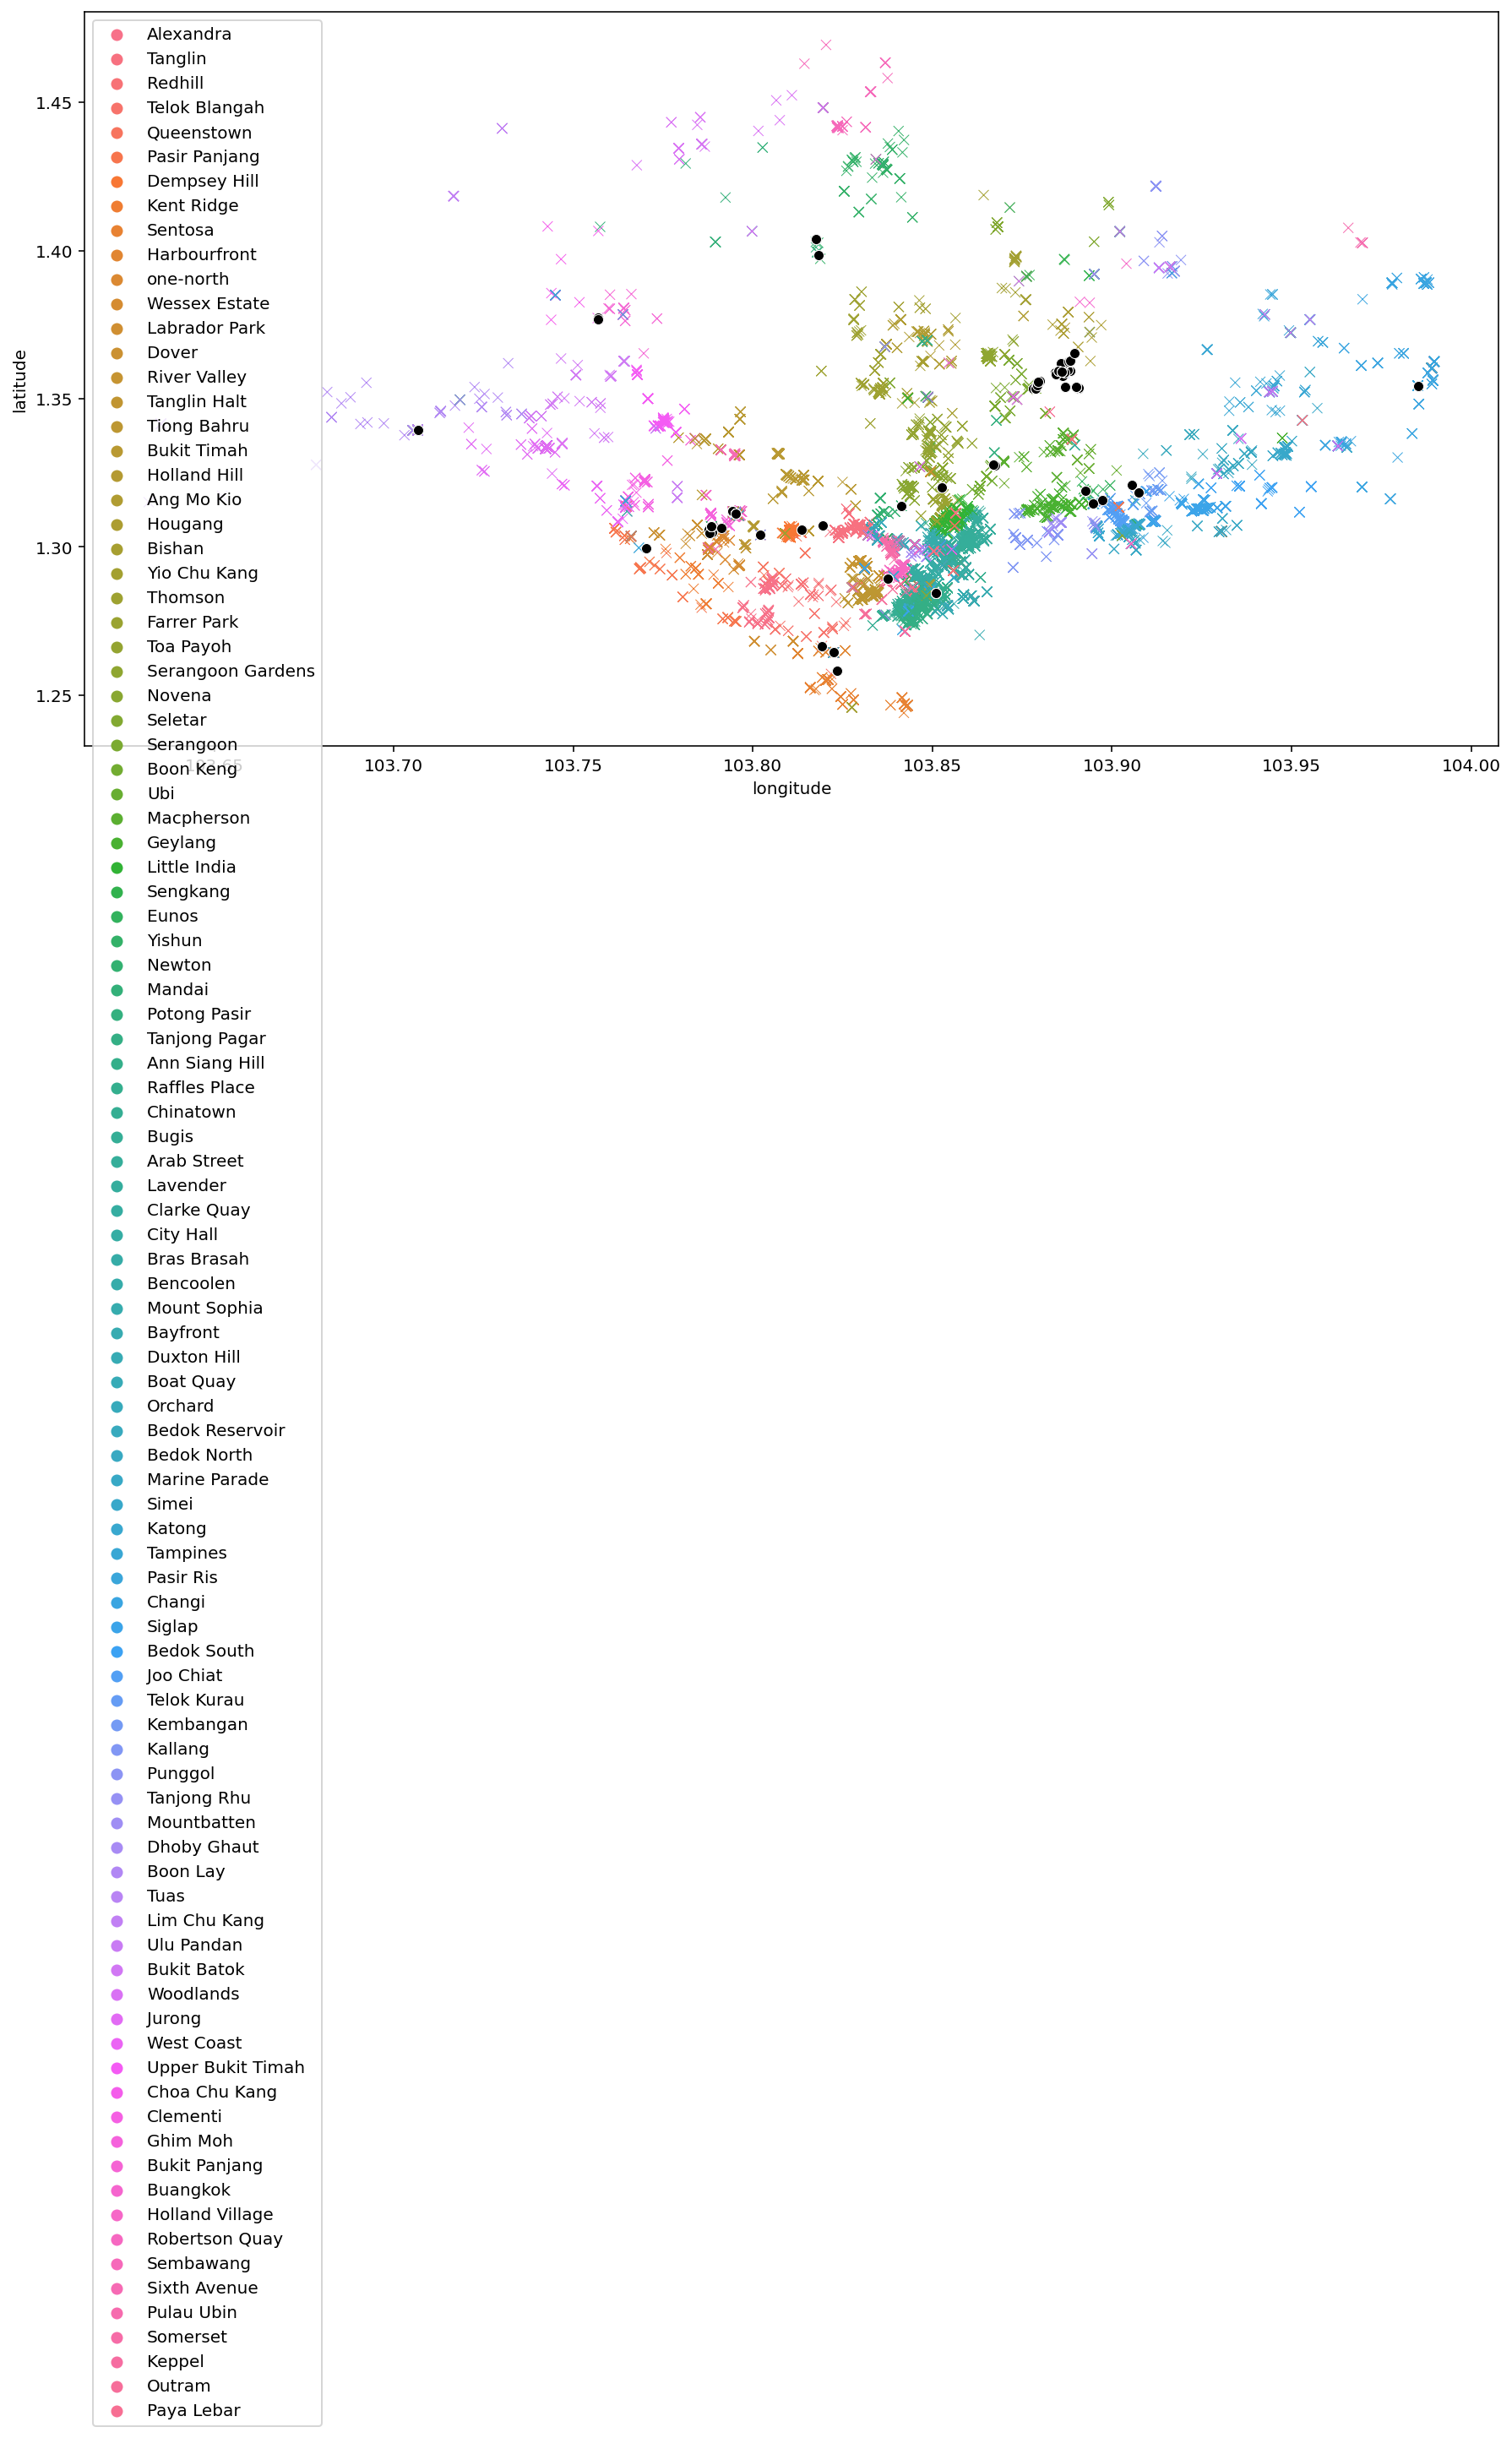

In [99]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=train, y='latitude', x='longitude', hue='location', marker='x');
sns.scatterplot(data=missing_loc_df, y='latitude', x='longitude', color='black');

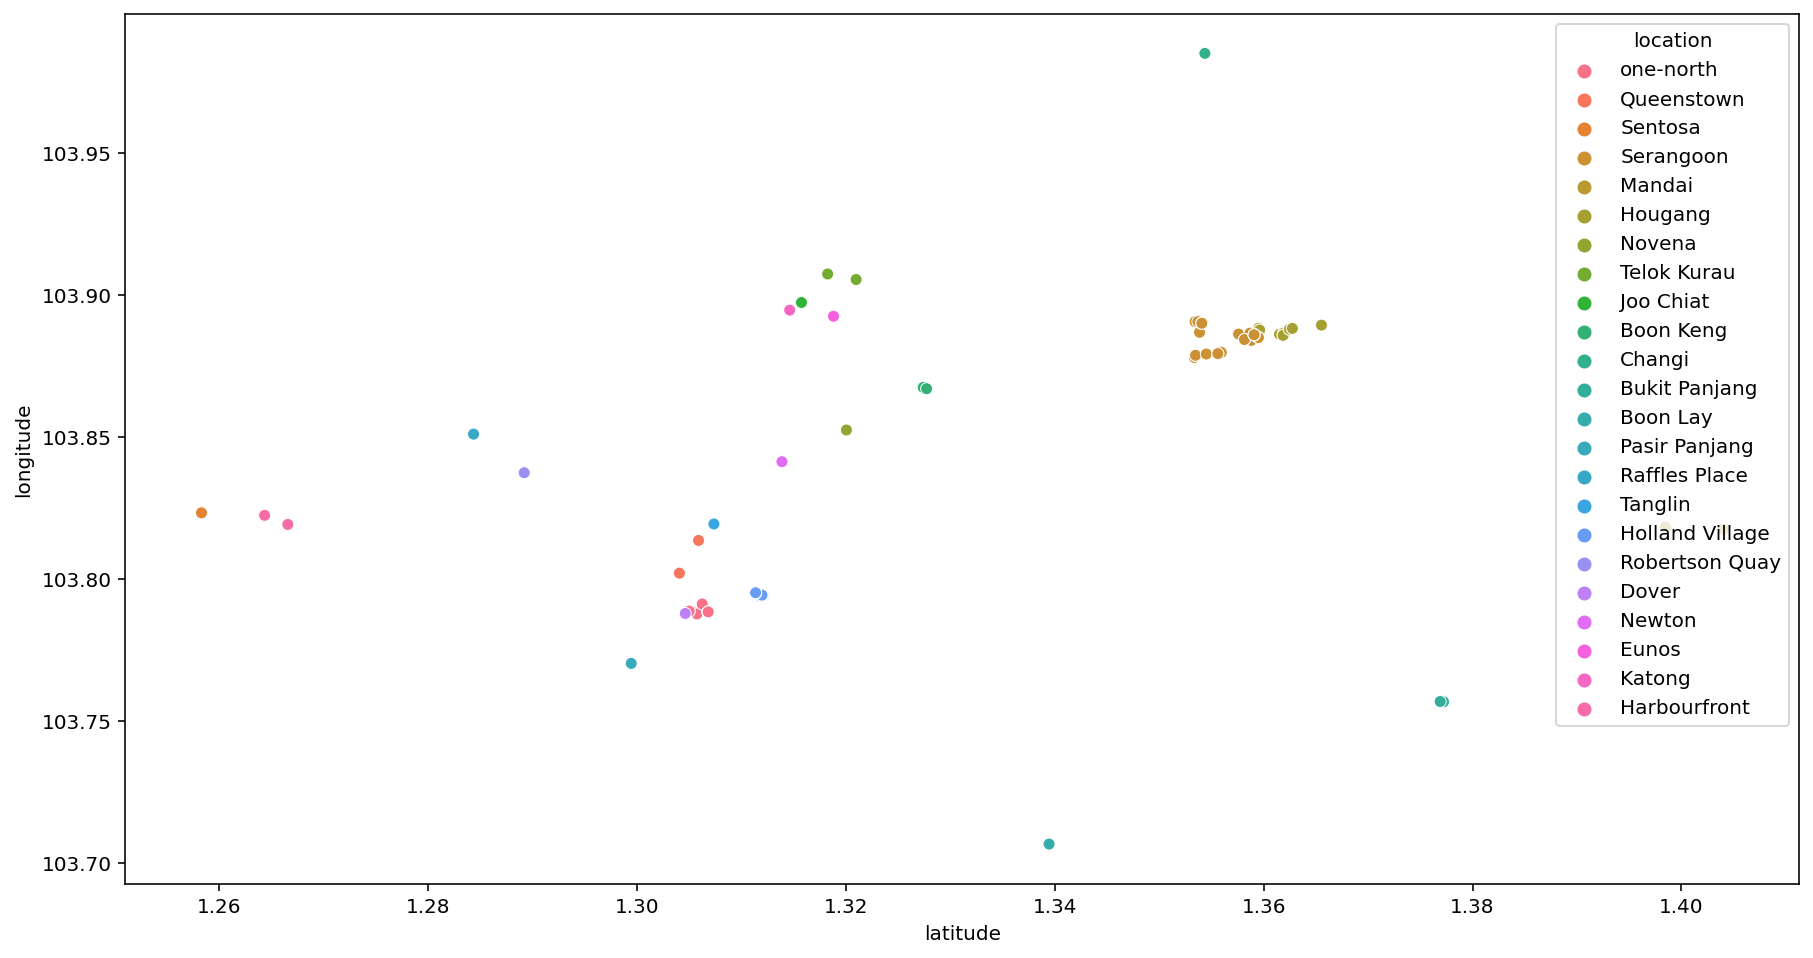

In [100]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=missing_loc_df, x='latitude', y='longitude', hue='location');

In [101]:
# modify dataframe columns name
# remove space
df.columns = df.columns.str.replace(' ', '_')

# convert to lowercase
df.columns = df.columns.str.lower()

In [102]:
# Re-arrange dataframe columns
rest_info_col = [
    'rest_name',
    'href',
    'address',
    'postal_code',
    'latitude',
    'longitude',
    'opening',
    'img',
    'star_rating',
    'review_count',
    'location',
    'price_range'
]

user_info_col = [
    'username',
    'userid',
    'user_location',
    'user_rating',
    'review_date',
    'comment'
]

cat_col = df.drop(columns = rest_info_col + user_info_col).columns.tolist()

df = df[rest_info_col + user_info_col + cat_col]

In [103]:
# Save merged dataframe
df.to_csv('../data/combined_data.csv', index=False)

## 3. Data Dictionary

**combined_data:**

|Features|Description|
|---|---|
|rest_name <br/> href<br/> address<br/> postal_code <br/> latitude<br/> longitude<br/> opening<br/> img<br/> star_rating<br/> review_count</br> location<br/> price_range|These are restaurant information.|
|username<br/> userid<br/> user_location<br/>|These are user information.|
|user_rating<br/> review_date<br/> comment<br/> |These are user's review information|
|category_{name}|These are restaurants' categories. Restaurans can have more than one category.|





read up
1. matrix factorisation 
2. 

# <center> END OF NOTEBOOK </center>